In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image

In [2]:
import random

# Set random seeds for reproducibility
seed = 2526
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
gym.utils.seeding.np_random(seed)

(Generator(PCG64) at 0x154CDB300, 2526)

## Hyperparameters

In [3]:
learning_rate = 0.01
gamma = 0.99
n_episodes = 1000
max_steps_per_episode = 200

## Policy Network

In [4]:
class PolicyNet(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_outputs),
            nn.Softmax(dim=-1) #Output a probablity distribution
        )
    def forward(self, x):
        return self.net(x)

## Discounted Rewards

In [5]:
def compute_discounted_returns(rewards, gamma):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)

    #Normalize for stability
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    return returns

## Training Loop

In [6]:
def train():
    env = gym.make('CartPole-v1')
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy = PolicyNet(obs_dim, 128, n_actions)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    episode_rewards = []

    for episode in range(n_episodes):
        obs, _ = env.reset(seed=seed)
        log_probs = []
        rewards = []

        for step in range(max_steps_per_episode):
            obs_tensor = torch.tensor(obs,dtype=torch.float32)
            action_probs = policy(obs_tensor)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()

            log_prob = dist.log_prob(action)
            obs, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                break
        returns = compute_discounted_returns(rewards, gamma)

        loss = sum(-log_prob * G for log_prob, G in zip(log_probs, returns))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_reward = sum(rewards)
        episode_rewards.append(total_reward)

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    env.close()
    return episode_rewards, policy

## Visualization

In [7]:
def plot_rewards(rewards):
    plt.plot(rewards, label = 'Episode reward')
    plt.plot(
        np.convolve(rewards, np.ones(10)/10, mode='valid'),
        label='Moving average(10 episodes)'
    )

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Policy Gradient Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

## Visualize the trained policy


In [8]:
def record_policy_as_gif(policy, filename="cartpole_agent.gif", max_steps=200):
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, _ = env.reset(seed=seed)

    frames = []
    total_reward = 0

    for step in range(max_steps):
        obs_tensor = torch.tensor(obs, dtype=torch.float32)
        with torch.no_grad():
            action_probs = policy(obs_tensor)
        action = torch.argmax(action_probs).item()
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        frame = env.render()
        frames.append(frame)

        if terminated or truncated:
            break

    env.close()
    
    # Save to GIF
    imageio.mimsave(filename, frames, fps=30)
    print(f"🎥 Saved agent's episode as {filename} (Total reward: {total_reward})")

## Run

Episode 50: Total Reward = 22.0
Episode 100: Total Reward = 101.0
Episode 150: Total Reward = 200.0
Episode 200: Total Reward = 178.0
Episode 250: Total Reward = 132.0
Episode 300: Total Reward = 49.0
Episode 350: Total Reward = 75.0
Episode 400: Total Reward = 86.0
Episode 450: Total Reward = 163.0
Episode 500: Total Reward = 64.0
Episode 550: Total Reward = 140.0
Episode 600: Total Reward = 85.0
Episode 650: Total Reward = 200.0
Episode 700: Total Reward = 180.0
Episode 750: Total Reward = 200.0
Episode 800: Total Reward = 200.0
Episode 850: Total Reward = 200.0
Episode 900: Total Reward = 48.0
Episode 950: Total Reward = 158.0
Episode 1000: Total Reward = 200.0


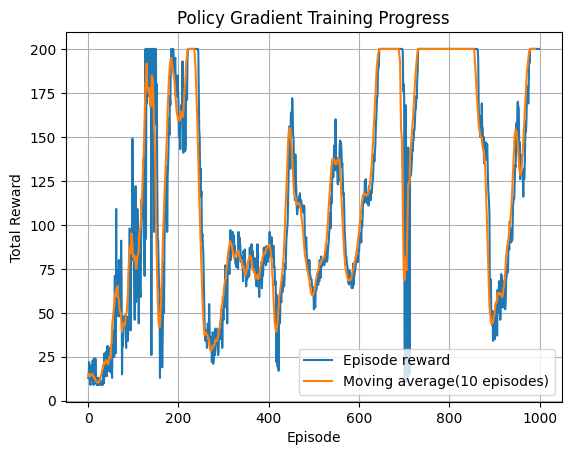

In [9]:
rewards, trained_policy = train()
plot_rewards(rewards)

🎥 Saved agent's episode as cartpole_agent.gif (Total reward: 200.0)


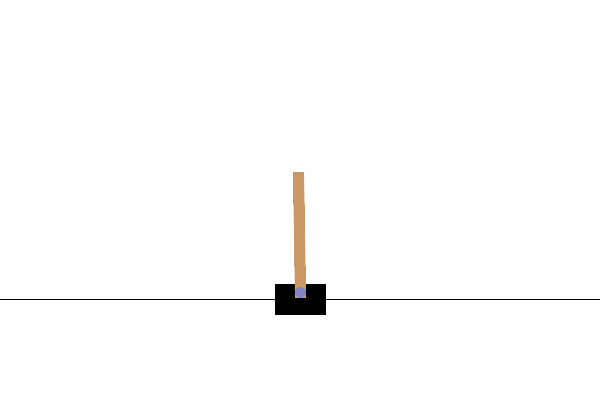

: 

In [ ]:
record_policy_as_gif(trained_policy)
Image(filename="cartpole_agent.gif")